<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#BKK-Data" data-toc-modified-id="BKK-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>BKK Data</a></span></li><li><span><a href="#Fire-Zone" data-toc-modified-id="Fire-Zone-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Fire Zone</a></span></li><li><span><a href="#Analyze-Fire-Activities" data-toc-modified-id="Analyze-Fire-Activities-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Analyze Fire Activities</a></span><ul class="toc-item"><li><span><a href="#Landuse" data-toc-modified-id="Landuse-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Landuse</a></span></li><li><span><a href="#Repeating-Hotspots" data-toc-modified-id="Repeating-Hotspots-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Repeating Hotspots</a></span></li></ul></li></ul></div>

In [43]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload
from pathlib import Path

#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
from src.imports import *
from src.gen_functions import *
from src.features.dataset import Dataset
from src.features.build_features import *
from src.visualization.vis_data import *
from src.data.fire_data import cal_repeat_spots_ex_year, cal_repeat_spots

import seaborn as sns
output_notebook()
plt.rcParams.update({'font.size': 14})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

# BKK Data 

In [161]:
# start building dataset from scratch only perform this when new data files are added 
dataset = Dataset('Bangkok')
dataset.build_all_data( build_fire=True, build_holiday = True)

th_stations ['02t', '03t', '05t', '11t', '12t', '50t', '52t', '53t', '59t', '61t']
Averaging data from 11 stations
Loading all hotspots data. This might take sometimes
before drop (3690516, 18)
after drop (3571928, 10)
Getting holiday for  thailand


In [162]:
# reinit the data and load saved process data 
dataset = Dataset('Bangkok')
dataset.load_()
# merge pollution data with other data except fire
dataset.feature_no_fire()

data no fire has shape (54587, 14)


Index(['PM2.5', 'PM10', 'O3', 'CO', 'NO2', 'SO2'], dtype='object')


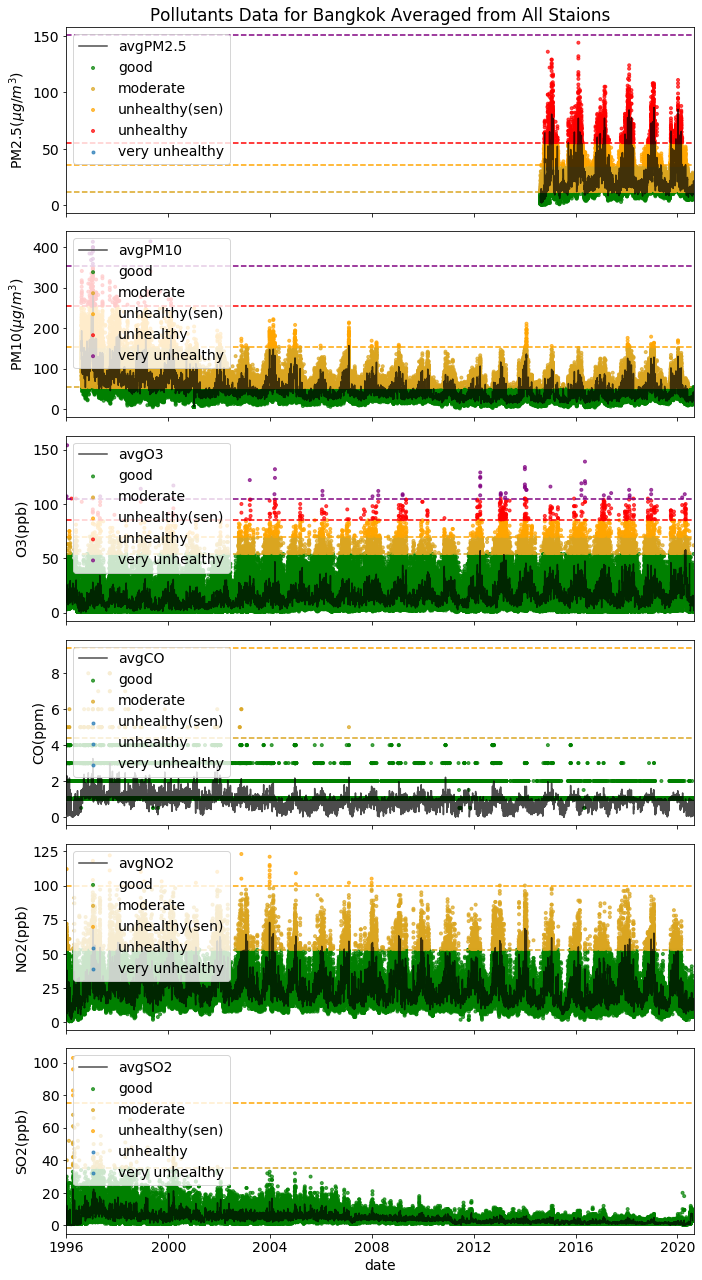

In [3]:
# plot the raw data
plot_all_pollutions(dataset.poll_df, city_name=dataset.city_name)

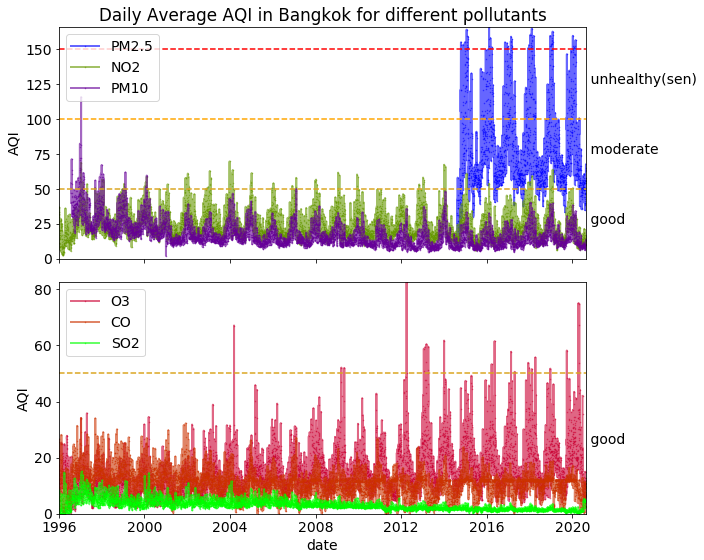

In [4]:
plot_polls_aqi(dataset.poll_df.copy(), dataset.roll_dict, dataset.city_name, filename=dataset.report_folder + 'all_pol_aqi.png' )

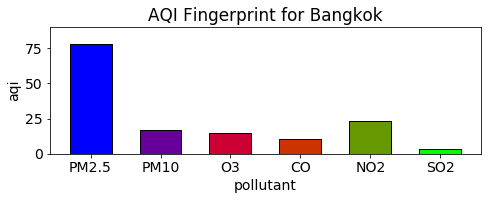

In [6]:
plot_chem_print(poll_to_aqi(dataset.poll_df.copy(), dataset.roll_dict).mean(axis=0), dataset.city_name, filename=dataset.report_folder + 'fingerprint.png')

aqi 100 in  11-05 to 03-28


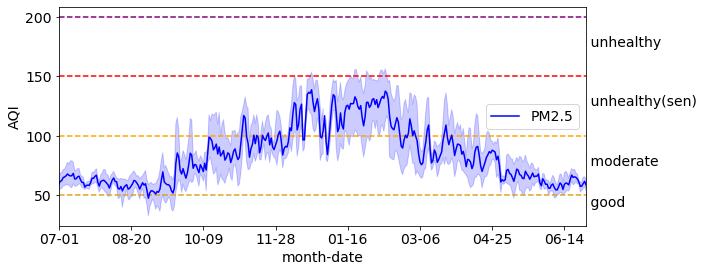

In [5]:
plot_season_aqi(dataset.poll_df.copy(), dataset.roll_dict, 'PM2.5', filename=dataset.report_folder + 'seasonal_pattern_PM25.png')

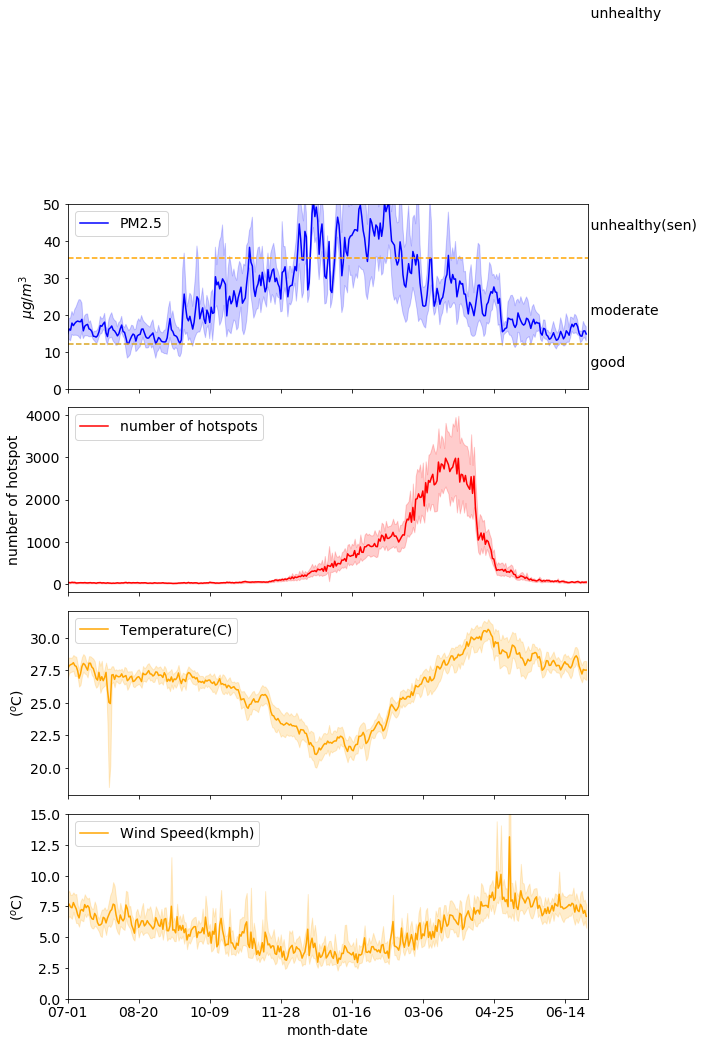

In [9]:
ax = compare_seson_avg(dataset, agg='mean')
ax[0].set_ylim([0, 55])
ax[3].set_ylim([0,15])

plt.savefig(dataset.report_folder + 'fire_PM25_season.png')

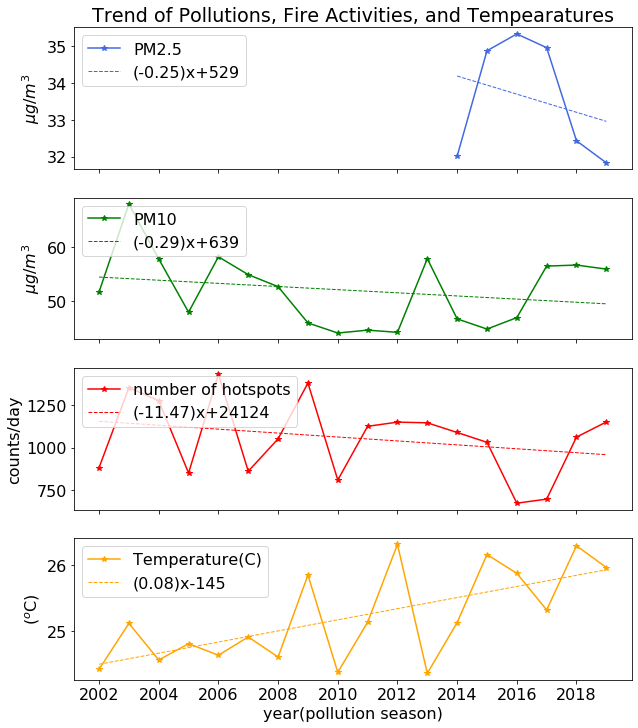

In [331]:
ax, year_avg = plot_yearly_ln(dataset, start_month='-11-01', end_month='-03-31', filename=dataset.report_folder + 'compare_ln_trends.png')

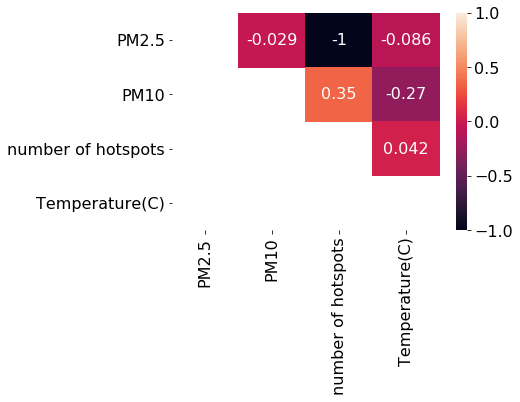

In [332]:
plot_corr(year_avg, figsize=(6,4))

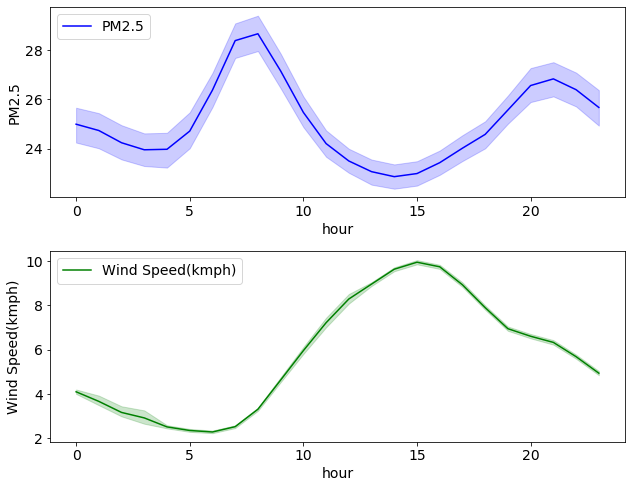

In [19]:
_, ax = plt.subplots(2, 1, figsize=(9, 7))
plot_hour_avg(dataset.poll_df.copy(), 'PM2.5', ax[0],  color='blue')
plot_hour_avg(dataset.wea.copy(), 'Wind_Speed(kmph)', ax[1],  color='green')
plt.tight_layout()

# Fire Zone 

In [28]:
dataset = Dataset('Bangkok')

In [29]:
dataset.city_info

x = dataset.city_info['long_m']
y = dataset.city_info['lat_m']
#stepx = 2E5

stepx = 1E6
stepy = stepx

In [31]:
# range bounds supplied in web mercator coordinates
p = figure(x_range=(x-0.5*stepx,x+0.5*stepx), y_range=(y-stepy*0.1, y+stepy*0.0001),
           x_axis_type="mercator", y_axis_type="mercator",
          title = dataset.city_name)
p.add_tile(get_provider(Vendors.STAMEN_TERRAIN_RETINA))



# plot hotspots at the begining and end of winter season

#p.scatter(fire1['long_km']*1000,fire1['lat_km']*1000,color='red',size=1, alpha=0.5,legend_label='fire in Mar 2019')

#p.scatter(fire2['long_km']*1000,fire2['lat_km']*1000,color='blue',size=1, alpha=0.5, legend_label='fire in Dec 2018')

#add circles
labels = ['0-100km','100-200km','200-400km','400-600km']

rs = [100, 200, 400, 600]
rs.reverse()
colors = get_color(color_length=len(labels),cmap=cm.jet)
for i, (r, label, color) in enumerate(zip(rs, labels, colors)):
    if i ==3 or i ==2:
        alpha=0.4
    else:
        alpha=0.2
        
    xy = get_circle(x,y,r=r*1E3)
    p.patch(xy[0,:],xy[1,:],alpha=alpha,line_width=2,line_color='black',color=color, legend_label=label)
    
# add city center
p.scatter(x,y,color='red',line_color='black',size=10, legend_label=dataset.city_name)
    
p.legend.location = "bottom_right"
wmark_bokeh(p)

show(p)
export_png(p, filename=dataset.report_folder + "fire_zone.png")

'C:\\Users\\Benny\\Documents\\Fern\\aqi_thailand2\\reports\\bangkok\\fire_zone.png'

# Analyze Fire Activities

## Landuse

In [35]:
dataset = Dataset('Bangkok')
# label location of the fire using landuse data around chiang mai
# this command generate another file named '../data/chiang_mai/' + 'fire_m_label.csv' 
# I don't wanna save over the old file to prevent accidently save over the labeling information 
fire = pd.read_csv('../data/bangkok/' + 'fire_m_label.csv')
fire['datetime'] = pd.to_datetime(fire['datetime'])
# add season information because I would like to consider the fire in pollution season only
fire = add_season(fire.set_index('datetime'), start_month='-11-01', end_month='-03-31')
fire = fire[fire['season'] != 'other']
fire['count'] = 1
fire.head()

,latitude,longitude,distance,long_km,lat_km,LC_Prop2,LC_Prop2_label,LC_Type1,LC_Type1_label,LC_Type5,LC_Type5_label,label,country,year,season,count
datetime,,,,,,,,,,,,,,,,
2002-11-01 01:22:00,9.7523,107.9843,948.999204,12020.757290,1090.901345,3,water,17,water,0,water,water,NaN,2002,winter_2002,1
2002-11-01 01:22:00,9.8279,108.0299,949.410042,12025.833458,1099.441467,3,water,17,water,0,water,water,NaN,2002,winter_2002,1
2002-11-01 01:22:00,9.8383,108.0219,948.071689,12024.942903,1100.616451,3,water,17,water,0,water,water,NaN,2002,winter_2002,1
2002-11-01 01:24:00,4.6312,104.8100,1136.003442,11667.395830,516.105122,3,water,17,water,0,water,water,NaN,2002,winter_2002,1
2002-11-01 10:47:00,22.9105,103.9187,1140.432654,11568.176768,2621.198709,20,forest,6,shrubland,2,forest,shrubland,China,2002,winter_2002,1


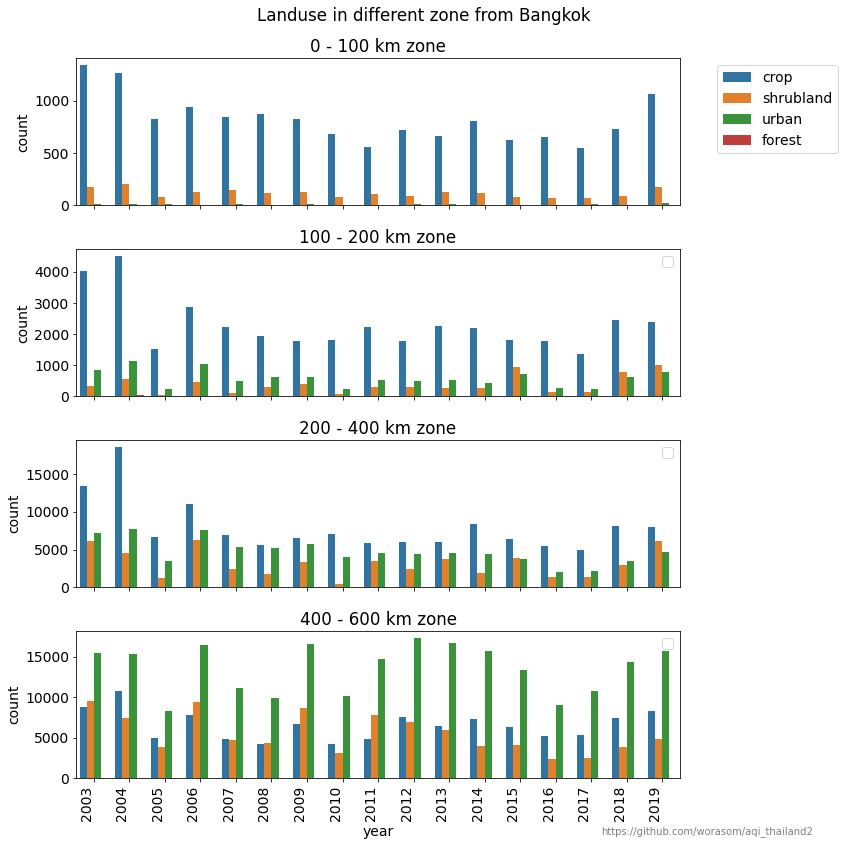

In [48]:
zone_list = dataset.zone_list[:5]
prop_type = 'label'

fig, ax = plt.subplots(len(zone_list[:-1]),1, figsize=(12, 3*len(zone_list[:-1])), sharex=True)


for i, (a, min_d, max_d) in enumerate(zip(ax, zone_list, zone_list[1:])):
    temp = fire[(fire['distance']< max_d) & (fire['distance'] >= min_d)]
    temp = temp.groupby(['year', prop_type], as_index=False)['count'].count()
    temp = temp[~temp[prop_type].isin(['water', 'unclassified'])]
    temp = temp[temp['year'] !=2002]
    
    sns.barplot(x="year", y="count", hue=prop_type, data=temp, ax=a)
    a.set_title(f'{min_d} - {max_d} km zone')
    if i==0:
        a.legend(bbox_to_anchor=(1.05, 1))
    else:
        a.legend([])
        
    a.set_xlabel('')

a.set_xlabel('year')
a.set_xticklabels(a.get_xticklabels(), rotation=90, ha='right');
# add super title
fig.suptitle(f'Landuse in different zone from {dataset.city_name}')

plt.tight_layout()
wmark_plt(fig)

plt.savefig(dataset.report_folder + 'landuse_firezone.png')

## Repeating Hotspots

Calculate repetition rate of the fire in 600 km zone, separated by countries

In [59]:
# select fire in 600 km zone
max_distance = 600
subfire = fire[fire['distance'] <=max_distance]

In [61]:
subfire['count'] = 1
fire_no_nan = subfire[~subfire['country'].isna()]
country_list = fire_no_nan['country'].unique() 
country_list.sort()
# repeating hotspots  between year
repeat_out_year = []
repeat_list = [2, 4, 6, 8]
for country in country_list:
    s = cal_repeat_spots_ex_year(fire_no_nan[fire_no_nan['country']==country], repeat_list=repeat_list,accum=False)
    s.name = country 
    repeat_out_year.append(s)
    
repeat_out_year  =  pd.concat(repeat_out_year,axis=1)

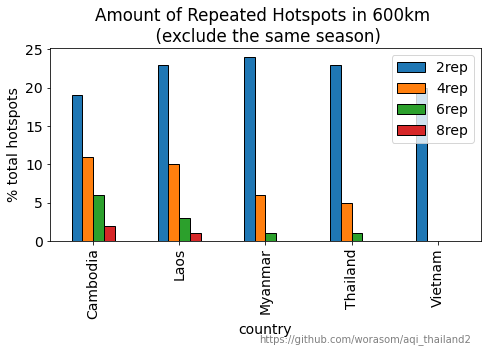

In [62]:
fig, ax = plt.subplots(1,1,figsize=(7,5))

color_list = get_color(color_length=len(country_list),cmap=cm.brg)

repeat_out_year.transpose().plot.bar(ax=ax, width=0.5, edgecolor='black',legend=None)


ti = f'Amount of Repeated Hotspots in {max_distance}km \n (exclude the same season)'

ax.set_title(ti)
ax.set_xlabel('country')
ax.set_ylabel('% total hotspots')

ax.legend(['2rep', '4rep','6rep','8rep'])
wmark_plt(fig)
    
plt.tight_layout()

plt.savefig(dataset.report_folder + 'fire_repeat_no_accum.png')

In [63]:
subfire['count'] = 1
fire_no_nan = subfire[~subfire['country'].isna()]
country_list = fire_no_nan['country'].unique() 
country_list.sort()
# repeating hotspots  between year
repeat_out_year_accum = []
repeat_list = [4]
for country in country_list:
    s = cal_repeat_spots_ex_year(fire_no_nan[fire_no_nan['country']==country], repeat_list=repeat_list,accum=True)
    s.name = country 
    repeat_out_year_accum.append(s)
    
repeat_out_year_accum =   pd.concat(repeat_out_year_accum,axis=1)

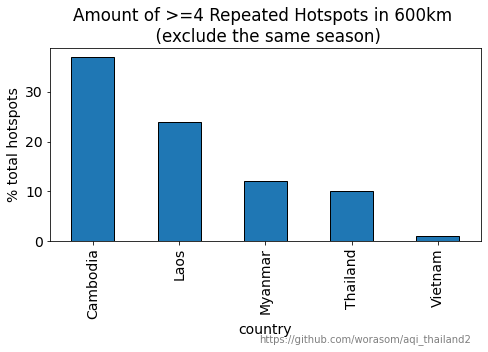

In [64]:
fig, ax = plt.subplots(1,1,figsize=(7,5))

color_list = get_color(color_length=len(country_list),cmap=cm.brg)

repeat_out_year_accum.transpose().plot.bar(ax=ax, width=0.5, edgecolor='black',legend=None)


ti = f'Amount of >=4 Repeated Hotspots in {max_distance}km \n (exclude the same season)'

ax.set_title(ti)
ax.set_xlabel('country')
ax.set_ylabel('% total hotspots')

wmark_plt(fig)
    
plt.tight_layout()
plt.savefig(dataset.report_folder + 'fire_repeat_accum.png')